## Import the list of tools ##

In [20]:
from utils import *

## The expression below describes the mass and width of the $\rho^0$ meson, a bound state of $u\bar{u}$ or $d\bar{d}$ quarks with spin=1, that predominantly decays into $\pi^+\pi^-$ ($\pi^{+,-}$ is a bound state of an $u\bar{d}$ or $d\bar{u}$ quarks. The parameters $m_{\rho^0}$, $\Gamma_{\rho^0}$ denote the mass and width of the $\rho^0$ meson respectively. The probability of a $\rho^0$ meson to decay into $\pi^+\pi^-$ can be written as ##

$$\Gamma(\rho^0\rightarrow  \pi^+\pi^-) \propto \frac{m_{\pi^+\pi^-}^{2}\Gamma_{\rho^0}^{2}}{(m_{\pi^+\pi^-}^{2}-m_{\rho^0}^{2})^{2}+m_{\rho^0}^{2}\Gamma_{\rho^0}^{2}}$$

# Task A: Make sure you can follow the code snippet below and ask any questions at drop-in sessions #

## A Python function that returns a numerical value of the aforementioned decay probability is shown below: ##

In [21]:
def gamma(m,mass,width):
    m_sq = m**2
    mass_sq = mass**2
    width_sq = width**2
    gamma = width_sq*m_sq/((m_sq-mass_sq)**2+mass_sq*width_sq)
    return gamma

# Task B: Make sure you can follow and execute the code snippet below and ask any questions at drop-in sessions #

## The snippet below plots the decay probability of the $\rho^0$ as a function of the invariant mass of the $\pi^+\pi^-$ system, $m_{\pi\pi}$: ## 

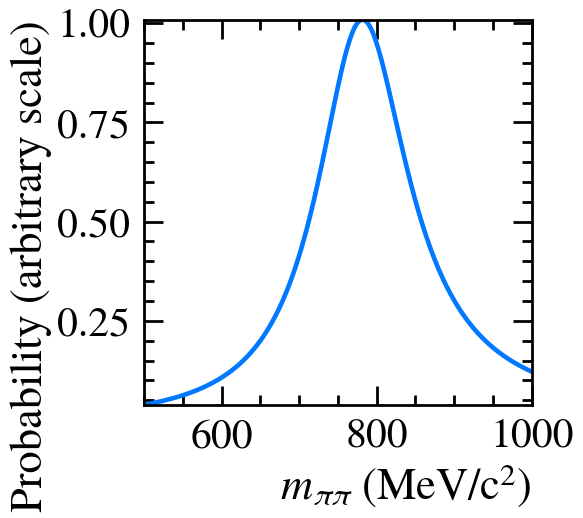

In [22]:
m_rho, g_rho = 775, 145   # in MeV/c^2 
m_pipi = np.linspace(500,1000,300)
prob   = gamma(m_pipi,m_rho,g_rho)
plt.figure(figsize=(5,5)) 
plt.tight_layout()
#plt.yscale('log')
plt.plot(m_pipi,prob)
plt.xlabel("$m_{\pi\pi}$ (MeV/c$^2$)")
plt.ylabel("Probability (arbitrary scale)")
plt.show()

# Task C: Make sure you can follow and execute the code snippet below and ask any questions at drop-in sessions #


## The cell below shows an example of how to generate some data according to the probability function given above, and then plotting a histogram of the generated values ## 

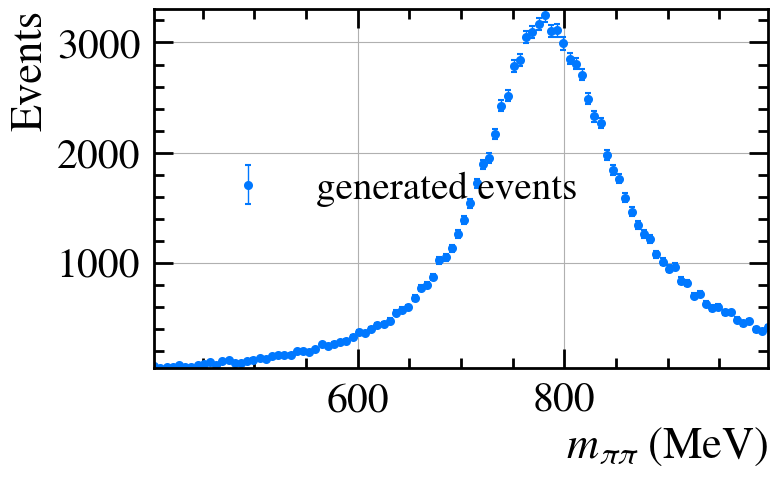

In [26]:
# Generate 1000000 values of sqrts according to the expression of the probability function defined
# above, within an mpipi range between m_min and m_max
n_events = 100000
m_min = 400
m_max = 1000
mpipi_vals = gen_data(n_events,gamma,x_min=m_min,x_max=m_max,mass=m_rho,width=g_rho)

# Plot a histogram of the data we just generated
hist, bin_edges = np.histogram(mpipi_vals, bins=100)
errors = np.sqrt(hist)

fig, ax = plt.subplots(figsize=(8,5))
hep.histplot(hist,bins=bin_edges,
    histtype="errorbar",yerr=errors,
    label="generated events",
    color="C0",ax=ax
)
ax.set_xlabel("$m_{\pi\pi}$ (MeV/c$^2$)")
ax.set_ylabel("Events")
ax.legend()
fig.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

# Task D: Make sure you can follow and execute the code snippet below and ask any questions at drop-in sessions #


## The cell below shows an example of how to create a cumulative distribution probability density function out of the decay probability function and feed it to a minimisation algorithm together with the generated data to determine $\Gamma_{\rho^0}$


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 108.5 (χ²/ndof = 1.1)      │              Nfcn = 47               │
│ EDM = 1.62e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

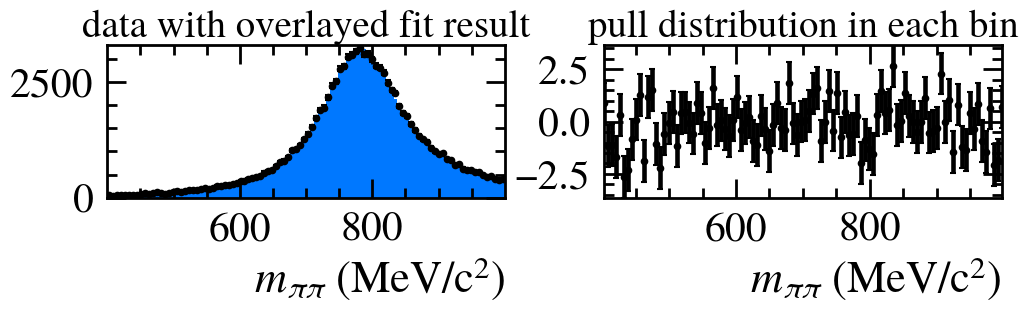

In [29]:
'''
The minimisation algorithm takes in the `toy` data we created in the previous cell, along with
the cdf function defined below and performs a fit to estimate the width and mass of the rho0 meson 
using a so-called binned negative log-likelihood cost function. We then print the result table 
as well as make a plot of the histogram and its fitted distribution
'''

# wrapper function of probability function that computes cdf to pass to minimiser
# TLDR: can replace the gamma function with ANY function you like
def gamma_cdf(bin_edges, *params):
    return func_cdf(gamma, bin_edges, *params)

# the parameters that the function depends on (need to match those appearing
# in the function all the way at the top of this notebook
names = ["mass", "width"]

# create the cost function to minimise to determine the parameters
# TLDR: can replace the gamma function with ANY function you like
cost = BinnedNLL(hist, bin_edges, gamma_cdf,name=names)

# Initialises the minimisation algorithm and takes starting values of the parameters we are fitting for
m = Minuit(cost, mass=770,width=150)
m.print_level = 0
migrad = m.migrad() # finds minimum of binned negative log likelihood function
hesse  = m.hesse()   # accurately computes uncertainties
print(hesse)      # print the fit result  

# visualise the result of the fit. The points are the original histogrammed values 
# and the blue histogram represents the binned function resulting from the fit to the histogram.
pred    = cost.prediction(m.values)
fig, ax = plt.subplots(1,2,figsize=(10, 3), constrained_layout=True)
plt.sca(ax[0])
plt.title("data with overlayed fit result")
ax[0].set_xlabel("$m_{\pi\pi}$ (MeV/c$^2$)")
cx = 0.5*(bin_edges[1:]+bin_edges[:-1])
plt.errorbar(cx,hist, errors, fmt="ok",markersize=4)
plt.stairs(pred, bin_edges, fill=True)

# the pull is defined for each histogram bin as: (N_{predicted}-N_{observed})/\sigma_{predicted}
pulls    = cost.pulls(m.values)
plt.sca(ax[1])
plt.title("pull distribution in each bin")
ax[1].set_xlabel("$m_{\pi\pi}$ (MeV/c$^2$)")
plt.errorbar(cx, pulls, 1, fmt="ok",markersize=4);
